In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.learner import ClassificationInterpretation
from fastai.metrics import error_rate

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/images/english_setter_77.jpg'),
 PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/images/Bengal_99.jpg'),
 PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/images/Bengal_89.jpg'),
 PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/images/havanese_47.jpg'),
 PosixPath('/home/oxape/.fastai/data/oxford-iiit-pet/images/Russian_Blue_127.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

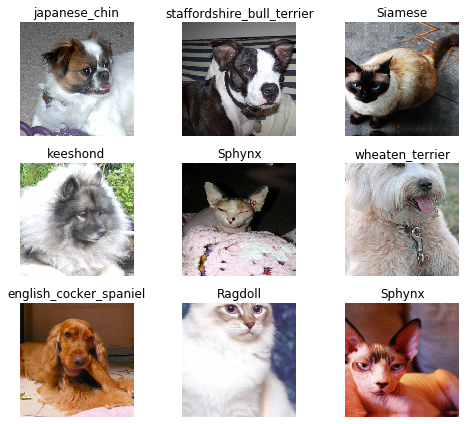

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# Training: resnet34

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.408970,0.408353,0.121786,00:17
1,0.629005,0.276300,0.097429,00:16
2,0.399135,0.245400,0.080514,00:16
3,0.278652,0.228276,0.076455,00:16


In [15]:
learn.save('stage-1')

# Results

In [16]:
interp =ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

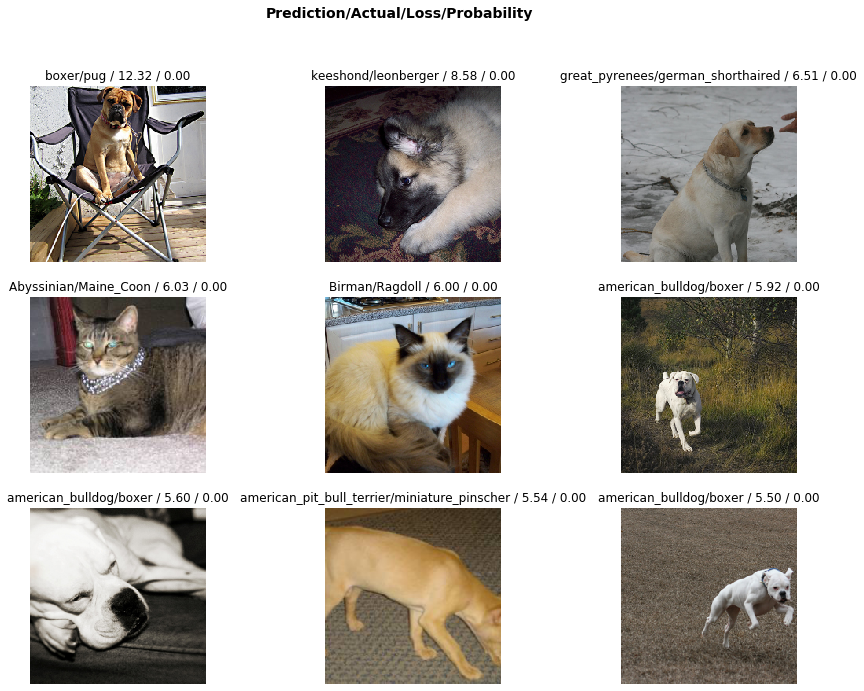

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

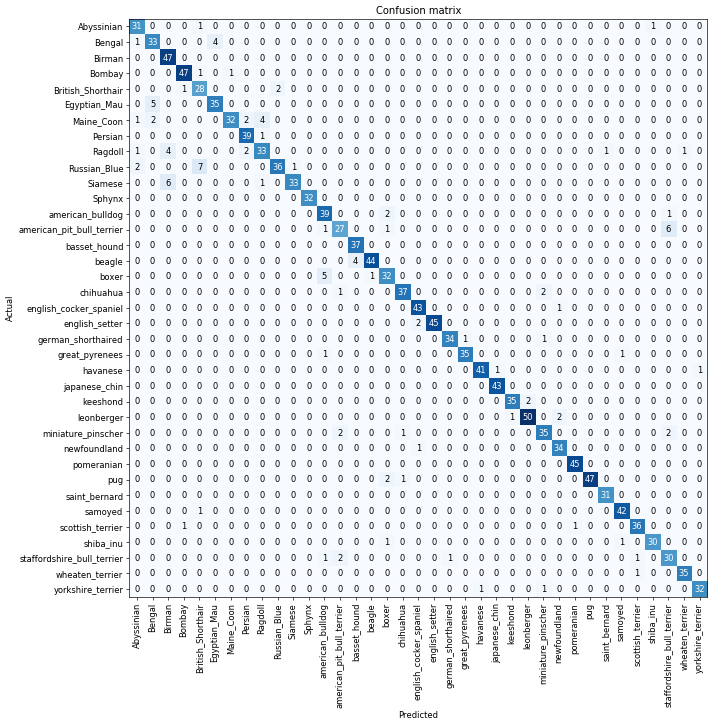

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
interp.most_confused(min_val=2)

[('Russian_Blue', 'British_Shorthair', 7),
 ('Siamese', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('boxer', 'american_bulldog', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Maine_Coon', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('beagle', 'basset_hound', 4),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('american_bulldog', 'boxer', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('keeshond', 'leonberger', 2),
 ('leonberger', 'newfoundland', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'staffordshire_bull_terrier', 2),
 ('pug', 'boxer', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

# Unfreezing, fine-tuning, and learning rates

In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.673094,0.427122,0.127876,00:19


In [22]:
learn.load('stage-1');

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


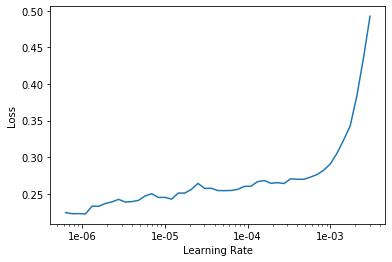

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.237691,0.218520,0.069689,00:19
1,0.210650,0.218840,0.071719,00:19


That's a pretty accurate model!

# Training: resnet50

In [26]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


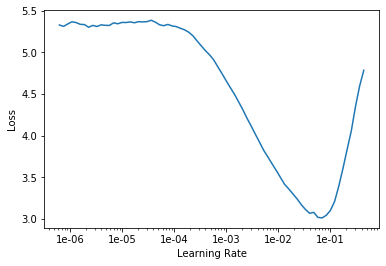

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.741447,0.310712,0.098782,00:50
1,0.501333,0.255940,0.075101,00:48
2,0.438480,0.265859,0.081867,00:49
3,0.336668,0.180041,0.049391,00:49
4,0.249487,0.159390,0.049391,00:49
5,0.209337,0.138246,0.039242,00:49
6,0.147680,0.125410,0.038566,00:49
7,0.107751,0.123710,0.042625,00:49


In [30]:
learn.save('stage-1-50')

In [31]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.104748,0.134127,0.043302,01:07
1,0.114009,0.129896,0.039919,01:05
2,0.090728,0.124307,0.038566,01:05


In [32]:
learn.load('stage-1-50');

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('yorkshire_terrier', 'havanese', 2)]